Please write your code in Jupyter Notebook or Google Colab. \
You need to compress the Jupyter notebook and your saved model checkpoint into a zip file and submit the zip file to Canvas. \
**Note**: Please restart the Jupyter notebook kernel and check if your code is executable before submission.

In this assignment, you need to implement a MobileNetV2 (https://arxiv.org/abs/1801.04381) for an image classification task. 
MobileNetV2 consists of many modules discussed in the class, such as 1x1 convolution layer, residual block, dropout, batch normalization.

Please train and evaluate the neural network on the CIFAR10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). 
The CIFAR10 dataset is a classic dataset for the image classification task, which consists of 60000 32x32 RGB images in 10 classes. 

**Hints:**
1. The original MobileNetV2 model is implemented on 224x224x3 images. You need to slightly change the model architecture to fit the image size of 32x32x3 in the CIFAR10 dataset.
2. You are strongly encouraged to use the deep learning frameworks (e.g., Pytorch, Tensorflow, Keras) for building the model, but other frameworks are allowed. 
3. You can use the basic modules (Fully Connected Layer, Convolution Layer, Dropout, Batch Normalization, etc) in these frameworks, but the existing implementation of MobileNet is not allowed to use in this assignment. However, it would be helpful for you to learn from the existing implementation.
4. You can use the CIFAR10 datasets provided by the frameworks (e.g., https://pytorch.org/vision/stable/datasets.html#cifar, https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10).

**This assignment will be graded as follows.**

1. (10 pts) Load and preprocess data from the CIFAR10 dataset.
1. (40 pts) Implement MobileNetV2 model.
2. (20 pts) Train the model using a proper optimization method and loss function.
3. (10 pts) Plot the training and test accuracy in each epoch (or iteration) in the Jupyter notebook.
4. (5 pts)  Save the weights of final model in the same directory of Jupyter notebook.
5. (5 pts)  Load the weights into your model and report the training and test accuracy.
4. (10 pts) Report the number of parameters used in each layer (You can use the function provided by the deep learning frameworks).
5. (10 pts) Bonus: The bonus points will be given if the test accuracy is higher than 90\%.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Flatten,Conv2D, DepthwiseConv2D, Input, Add, AveragePooling2D,Dense
from tensorflow.keras.optimizers import Adam,Nadam,SGD
from tensorflow.keras.losses import CategoricalCrossentropy,SparseCategoricalCrossentropy

In [2]:
num_classes = 10  
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

170500096/170498071 [==============================] - 3s 0us/step


In [3]:
print('Shape of X_train  : ', X_train.shape)
print('Shape of X_test : ', X_test.shape)
print('Shape of y_train : ', y_train.shape)
print('Shape of y_test : ', y_test.shape)

Shape of X_train  :  (50000, 32, 32, 3)
Shape of X_test :  (10000, 32, 32, 3)
Shape of y_train :  (50000, 10)
Shape of y_test :  (10000, 10)


In [4]:
X_train = X_train/255.0
X_test = X_test/255.0

In [5]:
def BottleNeck(input, t, c, s):
  inp_filters = input.shape[-1]
  if s == 1:
    conv_1 = Conv2D(filters = inp_filters * t, kernel_size = 1)(input)  
    BN = BatchNormalization()(conv_1)
    Relu6 = tf.keras.activations.relu(BN, max_value=6)
    
    Dwise_3 = DepthwiseConv2D(kernel_size=3, padding = 'same')(Relu6)
    BN = BatchNormalization()(Dwise_3)
    Relu6 = tf.keras.activations.relu(BN, max_value=6)

    conv_2 = Conv2D(filters = c, kernel_size = 1)(Relu6)  
    BN_out = BatchNormalization()(conv_2)

    if inp_filters != c:
        reduced = Conv2D(filters = c, kernel_size = 1)
        output = Add()([reduced(input), BN_out])
    else:
        output = Add()([input, BN_out])

    return output
    
  else:
    conv_1 = Conv2D(filters = inp_filters * t, kernel_size = 1)(input)  
    BN = BatchNormalization()(conv_1)
    Relu6 = tf.keras.activations.relu(BN, max_value=6)

    Dwise_3 = DepthwiseConv2D(kernel_size=3, padding = 'same', strides = s)(Relu6)
    BN = BatchNormalization()(Dwise_3)
    Relu6 = tf.keras.activations.relu(BN, max_value=6)

    conv_2 = Conv2D(filters = c, kernel_size = 1)(Relu6)  
    BN_out = BatchNormalization()(conv_2)

    return BN_out

In [6]:
tf.keras.backend.clear_session
tf.random.set_seed(16)
input = Input(shape=(img_height, img_width, channel,))

conv = Conv2D(filters = 32,activation='relu', kernel_size=3, strides=2)(input)
BN = BatchNormalization()(conv)
b = BottleNeck(BN, t = 1, c = 16, s = 1)

b = BottleNeck(b, t = 6, c = 24, s = 2)
b = BottleNeck(b, t = 6, c = 24, s = 2)

b = BottleNeck(b, t = 6, c = 32, s = 2)
b = BottleNeck(b, t = 6, c = 32, s = 2)
b = BottleNeck(b, t = 6, c = 32, s = 2)

b = BottleNeck(b, t = 6, c = 64, s = 2)
b = BottleNeck(b, t = 6, c = 64, s = 2)
b = BottleNeck(b, t = 6, c = 64, s = 2)
b = BottleNeck(b, t = 6, c = 64, s = 2)

b = BottleNeck(b, t = 6, c = 96, s = 1)
b = BottleNeck(b, t = 6, c = 96, s = 1)
b = BottleNeck(b, t = 6, c = 96, s = 1)

b = BottleNeck(b, t = 6, c = 160, s = 2)
b = BottleNeck(b, t = 6, c = 160, s = 2)
b = BottleNeck(b, t = 6, c = 160, s = 2)

b = BottleNeck(b, t = 6, c = 320, s = 1)

conv = Conv2D(filters = 1280,activation='relu', kernel_size=1)(b)
BN = BatchNormalization()(conv)

avgpool = AveragePooling2D(pool_size=(7, 7), padding='same')(BN)

conv = Conv2D(filters = 10, kernel_size=1)(avgpool)
BN = BatchNormalization()(conv)

output = Flatten()(BN)
output = Dense(128)(output)
output = Dense(num_classes, activation='softmax')(output)
model = Model(inputs=[input], outputs=[output])

In [7]:
model.compile(loss=CategoricalCrossentropy(),
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [8]:
history= model.fit(X_train,y_train,batch_size=128,epochs=100,verbose=1)

Epoch 1/100
391/391 [==============================] - 50s 33ms/step - loss: 2.2787 - accuracy: 0.1326
Epoch 2/100
391/391 [==============================] - 12s 31ms/step - loss: 1.8851 - accuracy: 0.2597
Epoch 3/100
391/391 [==============================] - 12s 31ms/step - loss: 1.7004 - accuracy: 0.3409
Epoch 4/100
391/391 [==============================] - 12s 32ms/step - loss: 1.5803 - accuracy: 0.4010
Epoch 5/100
391/391 [==============================] - 12s 31ms/step - loss: 1.4808 - accuracy: 0.4529
Epoch 6/100
391/391 [==============================] - 12s 31ms/step - loss: 1.3961 - accuracy: 0.4895
Epoch 7/100
391/391 [==============================] - 12s 31ms/step - loss: 1.3545 - accuracy: 0.5129
Epoch 8/100
391/391 [==============================] - 12s 31ms/step - loss: 1.2743 - accuracy: 0.5483
Epoch 9/100
391/391 [==============================] - 12s 31ms/step - loss: 1.2133 - accuracy: 0.5734
Epoch 10/100
391/391 [==============================] - 12s 31ms/step - l

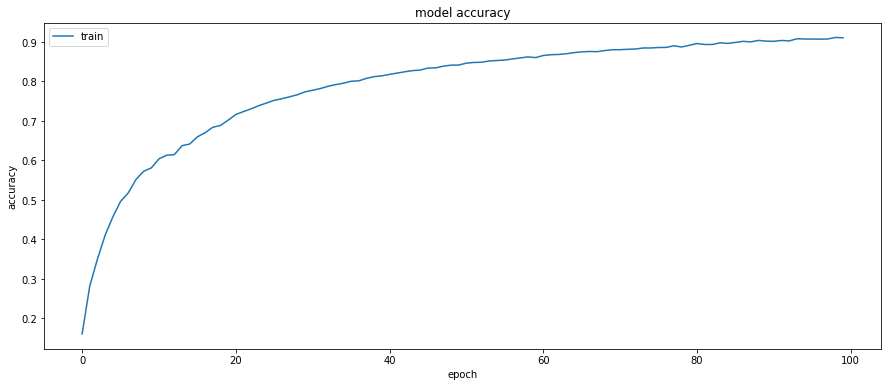

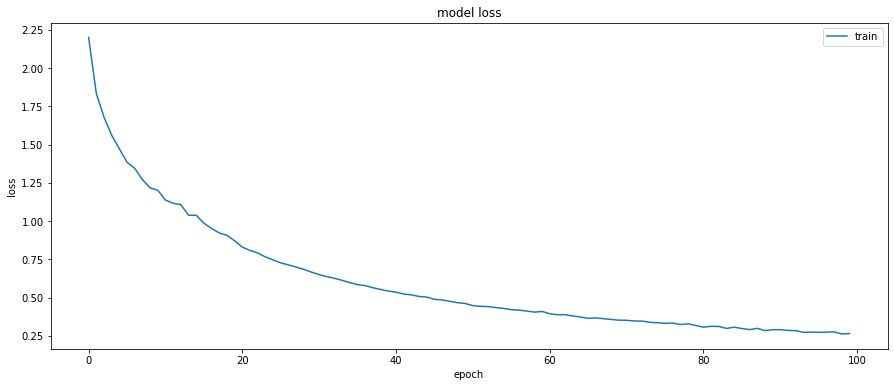

In [15]:
plt.figure(figsize=(15,6))
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

plt.figure(figsize=(15,6))
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [10]:
from google.colab import drive
drive.mount('/content/drive')
model.save_weights("/content/drive/My Drive/Colab Notebooks/MobileNet_weights.h5")
print("Saved model to disk as MobileNet_weights.h5")
saved_path = '/content/drive/My Drive/Colab Notebooks/MobileNet_weights.h5'
k = model.load_weights(saved_path)

Mounted at /content/drive
Saved model to disk as MobileNet_weights.h5


In [11]:
model.evaluate(X_train,y_train,sample_weight=k)

1563/1563 [==============================] - 16s 9ms/step - loss: 0.3251 - accuracy: 0.8929


[0.3250950872898102, 0.8928800225257874]

In [12]:
model.evaluate(X_test,y_test,sample_weight=k)

313/313 [==============================] - 3s 9ms/step - loss: 1.1840 - accuracy: 0.7016


[1.183961033821106, 0.7016000151634216]

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 15, 15, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 15, 15, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 15, 15, 32)   1056        batch_normalization[0][0]        
______________________________________________________________________________________________